In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

In [2]:
data = pd.read_csv("https://github.com/dustywhite7/Econ8310/raw/master/AssignmentData/cookie_cats.csv")
data.head()


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
#Splitting the data into control and treatment groups
gate30_ret1 = data[data['version'] == 'gate_30']['retention_1']
gate40_ret1 = data[data['version'] == 'gate_40']['retention_1']

gate30_ret7 = data[data['version'] == 'gate_30']['retention_7']
gate40_ret7 = data[data['version'] == 'gate_40']['retention_7']

In [4]:
gate30_ret1

,retention_1
0,False
1,True
6,False
11,False
13,True
...,...
90179,True
90180,False
90182,True
90183,False


In [5]:
#Now I calculate the observed success and sum of both groups
successes_ret1 = [gate30_ret1.sum(), gate40_ret1.sum()]
totals_ret1 = [len(gate30_ret1), len(gate40_ret1)]

successes_ret7 = [gate30_ret7.sum(), gate40_ret7.sum()]
totals_ret7 = [len(gate30_ret7), len(gate40_ret7)]

In [6]:

seed = 50805274

def bayesian_ab_test(successes, totals):
    with pm.Model() as model:
        # These are the priors for the two groups
        p1 = pm.Beta("p1", alpha=1, beta=1)
        p2 = pm.Beta("p2", alpha=1, beta=1)

        # Likelihood of observed data
        obs1 = pm.Binomial("obs1", n=totals[0], p=p1, observed=successes[0])
        obs2 = pm.Binomial("obs2", n=totals[1], p=p2, observed=successes[1])

        # Calculate the difference between the two probabilities
        delta = pm.Deterministic("delta", p2 - p1)

        # Perform sampling
        trace = pm.sample(2000, return_inferencedata=True, random_seed=seed)

    return trace

# A/B test for 1-day retention
trace_ret1 = bayesian_ab_test(successes_ret1, totals_ret1)

# A/B test for 7-day retention
trace_ret7 = bayesian_ab_test(successes_ret7, totals_ret7)

Output()

Output()

Output()

Output()

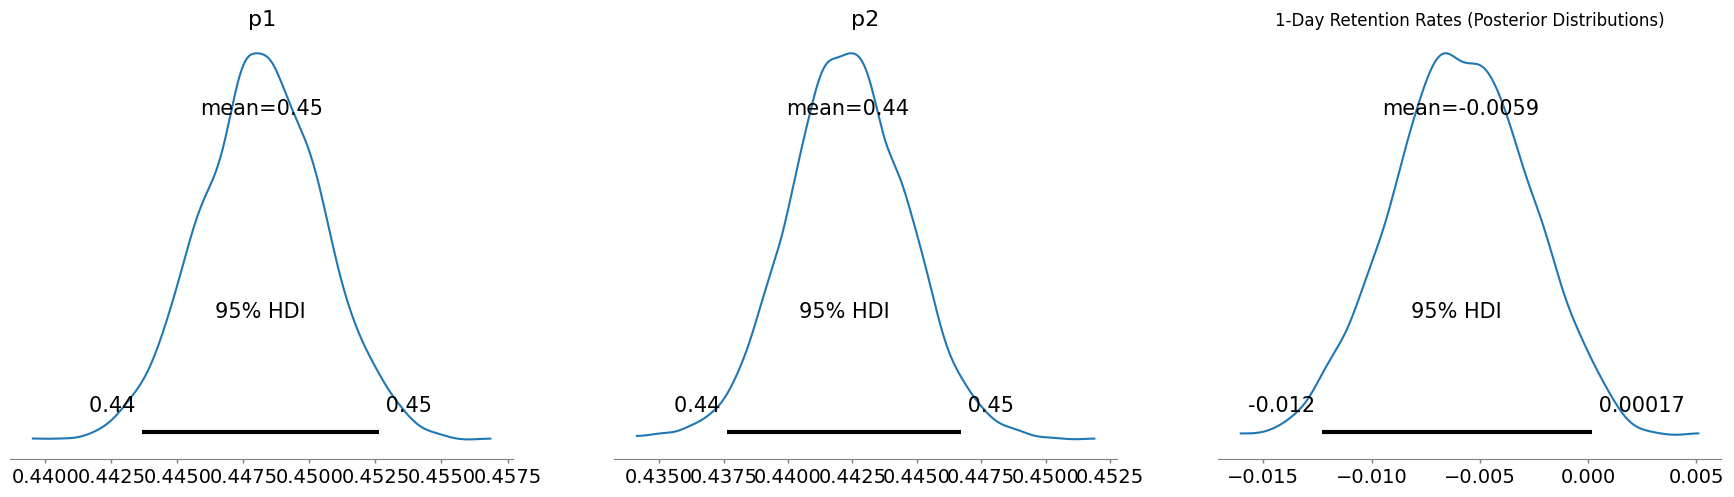

In [8]:
import arviz as az

# Posterior distributions for 1-day retention
az.plot_posterior(trace_ret1, var_names=["p1", "p2", "delta"], hdi_prob=0.95)
plt.title("1-Day Retention Rates (Posterior Distributions)")
plt.show()



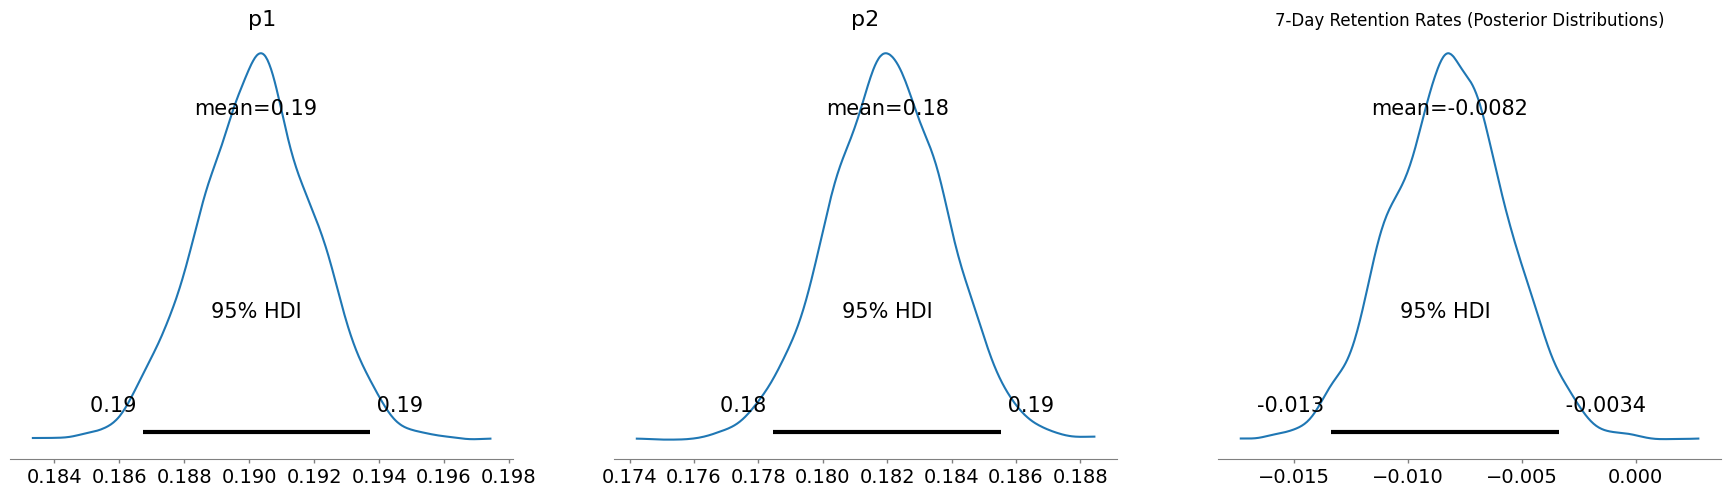

In [9]:
# Posterior distributions for 7-day retention
az.plot_posterior(trace_ret7, var_names=["p1", "p2", "delta"], hdi_prob=0.95)
plt.title("7-Day Retention Rates (Posterior Distributions)")
plt.show()

In [ ]:
### ALternatively

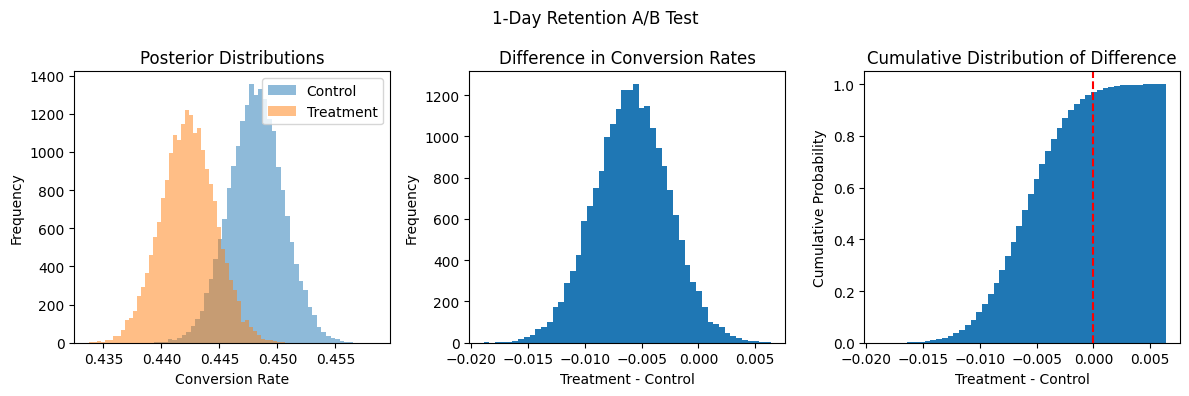

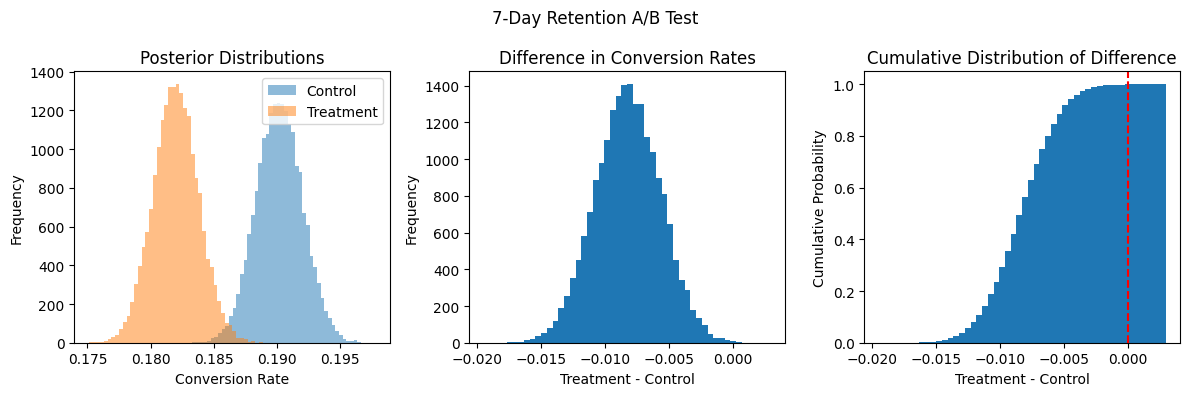

Probability of improvement (1-day retention): 3.61%
Probability of improvement (7-day retention): 0.07%


In [10]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def bayesian_ab_test(successes, totals, n_samples=20000):
    # Prior parameters (Beta(1,1) is uniform prior)
    prior_alpha = 1
    prior_beta = 1

    # Posterior parameters
    post_alpha1 = prior_alpha + successes[0]
    post_beta1 = prior_beta + (totals[0] - successes[0])
    post_alpha2 = prior_alpha + successes[1]
    post_beta2 = prior_beta + (totals[1] - successes[1])

    # Sample from posterior distributions
    samples1 = stats.beta.rvs(post_alpha1, post_beta1, size=n_samples)
    samples2 = stats.beta.rvs(post_alpha2, post_beta2, size=n_samples)

    # Calculate the difference
    delta = samples2 - samples1

    return samples1, samples2, delta

def plot_results(samples1, samples2, delta, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(131)
    plt.hist(samples1, bins=50, alpha=0.5, label='Control')
    plt.hist(samples2, bins=50, alpha=0.5, label='Treatment')
    plt.xlabel('Conversion Rate')
    plt.ylabel('Frequency')
    plt.title('Posterior Distributions')
    plt.legend()

    plt.subplot(132)
    plt.hist(delta, bins=50)
    plt.xlabel('Treatment - Control')
    plt.ylabel('Frequency')
    plt.title('Difference in Conversion Rates')

    plt.subplot(133)
    plt.axvline(0, color='r', linestyle='--')
    plt.hist(delta, bins=50, density=True, cumulative=True)
    plt.xlabel('Treatment - Control')
    plt.ylabel('Cumulative Probability')
    plt.title('Cumulative Distribution of Difference')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Set random seed
np.random.seed(50805274)

# A/B test for 1-day retention
samples1_ret1, samples2_ret1, delta_ret1 = bayesian_ab_test(successes_ret1, totals_ret1)
plot_results(samples1_ret1, samples2_ret1, delta_ret1, '1-Day Retention A/B Test')

# A/B test for 7-day retention
samples1_ret7, samples2_ret7, delta_ret7 = bayesian_ab_test(successes_ret7, totals_ret7)
plot_results(samples1_ret7, samples2_ret7, delta_ret7, '7-Day Retention A/B Test')

# Calculate probabilities
prob_improvement_ret1 = (delta_ret1 > 0).mean()
prob_improvement_ret7 = (delta_ret7 > 0).mean()

print(f"Probability of improvement (1-day retention): {prob_improvement_ret1:.2%}")
print(f"Probability of improvement (7-day retention): {prob_improvement_ret7:.2%}")
